<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/Assignments/M6_AST_07_Graph_Neural_Networks_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 7: Node Classification with Graph Neural Networks


## Learning Objectives


At the end of the experiment, you will be able to

* Understand what is Node Classification with Graph Neural Networks
* Perform real-time data analytics with Graph Neural Networks

## Information

### Introduction

Many datasets in various machine learning (ML) applications have structural relationships between their entities, which can be represented as graphs. Such application includes social and communication networks analysis, traffic prediction, and fraud detection. Graph representation Learning aims to build and train models for graph datasets to be used for a variety of ML tasks.

This example demonstrates a simple implementation of a Graph Neural Network (GNN) model. The model is used for a node prediction task on the Cora dataset to predict the subject of a paper given its words and citations network.

Note that, a Graph Convolution Layer is implemented in this notebook from scratch to provide better understanding of how they work. However, there is a number of specialized TensorFlow-based libraries that provide rich GNN APIs, such as Spectral, StellarGraph, and GraphNets.

## Dataset Description

The [Cora dataset](https://linqs.org/datasets/#cora) consists of 2,708 scientific papers classified into one of seven classes. The citation network consists of 5,429 links.
Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
For each publication (paper), there is a 0/1-valued word vector which is basically a binary word vector of size 1,433, indicating the absence/presence of a corresponding word.

### Setup Steps:

In [42]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}

In [43]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "M6_AST_07_Graph_Neural_Networks_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx wget https://cdn.exec.talentsprint.com/static/cds/content/cora.zip")
    !unzip /content/cora.zip
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://cds-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")

Archive:  /content/cora.zip
  inflating: cora/cora.cites         
  inflating: cora/cora.content       
  inflating: cora/README             


Setup completed successfully


# Importing required packages

In [4]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

As imported in the above code cell, the **networkx** library is a Python package used for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
This helps to implement an undirected graph, directed graphs, and multigraphs (graphs with multiple edges between nodes).
- **networkx** includes a wide range of graph algorithms, such as shortest path, clustering, and network flow algorithms to create graphs, add nodes and edges, and access various properties and attributes of the graph.
- **networkx** provides basic drawing capabilities to visualize graphs. Although not as advanced as specialized visualization libraries, it's useful for quick visualizations.
- The **networkx** library supports importing and exporting graph data from/to various formats like adjacency lists, edge lists and others

To know more about **networkx** library, please visit [NetworkX](https://networkx.org/documentation/stable/reference/introduction.html#networkx-basics)

# Prepare the Dataset
The following tasks are accomplished to prepare the dataset "cora" for further processing, visualization and to create the graph structure using NetworkX.
Both the files (i.e., cora.cites and cora.content) existing under the unzipped folder 'cora' in the data directory '/content/cora', will be used in the subsequent steps.

In [5]:
data_dir = '/content/cora'

# Process and visualize the dataset

As stated above, the dataset has two tap-separated files: cora.cites and cora.content.

The cora.cites includes the citation records with two columns: cited_paper_id (target) and citing_paper_id (source).
The cora.content includes the paper content records with 1,435 columns: paper_id, subject, and 1,433 binary features.

## Load data
Load the citations data into a Pandas DataFrame.

In [6]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


Display a sample of the citations DataFrame. The target column includes the paper ids cited by the paper ids in the source column.

In [7]:
citations.sample(frac=1).head()

,target,source
309,910,34355
4140,131315,411005
2591,28265,1152436
1459,6913,703953
704,3084,1107171


Now load the papers data into a Pandas DataFrame.

In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


Now display a sample of the papers DataFrame. The DataFrame includes the paper_id and the subject columns, as well as 1,433 binary column representing whether a term exists in the paper or not.

In [9]:
print(papers.sample(5).T)

             848                     412                    584   \
paper_id    45189                  136665                 390922   
term_0          0                       0                      0   
term_1          0                       0                      0   
term_2          0                       0                      0   
term_3          0                       0                      0   
...           ...                     ...                    ...   
term_1429       0                       0                      0   
term_1430       0                       0                      0   
term_1431       0                       0                      0   
term_1432       0                       0                      0   
subject    Theory  Reinforcement_Learning  Probabilistic_Methods   

                    348              1538  
paper_id          591016          1109185  
term_0                 0                0  
term_1                 0                0  
term_2 

From the above result, it is observed that,
- **paper_id** contains the unique ID for each paper. For example, paper IDs are 9515, 1110563, 219239, 1116629, and 1134056.
- **term_0 to term_1432:** It represent a sparse bag-of-words feature vector for the paper. Each term corresponds to a specific word in the corpus, and the binary values indicate whether that word appears (i.e., 1) or doesn't appear (i.e., 0) in the paper.
- **subject:** Provides the classification or category of each paper, which can be used as labels for training machine learning models.
- For instance in the above result, the paper having **paper_id 9515** does not contain any of the terms from term_0 to term_1432 and belongs to the subject category "Theory".
- And the paper having **paper_id 1110563** also does not contain any of the terms from term_0 to term_1432 and belongs to the subject category "Neural_Networks".

Display the count of the papers in each subject.

In [10]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


The above result of the command **papers.subject.value_counts()** provides the count of papers in each subject within the dataset.
1. Neural Networks: This subject has the highest number of papers, with a total of 818 papers. This suggests a strong focus or large amount of research in the field of neural networks.

2. Probabilistic Methods: The second most common subject, with 426 papers. This indicates a significant interest and research activity in probabilistic methods.

3. Genetic Algorithms: There are 418 papers in this subject, highlighting a substantial amount of work in the area of genetic algorithms.

4. Theory: This subject has 351 papers. Theory-related research is also well-represented in the dataset.

5. Case-Based: With 298 papers, case-based methods are another important area of research covered in this dataset.

6. Reinforcement Learning: There are 217 papers focused on reinforcement learning. This is a smaller but still notable area of research.

7. Rule Learning: The subject with the fewest papers, having 180 papers. This suggests relatively less research activity in rule learning compared to the other subjects.

Convert the paper ids and the subjects into zero-based indices.

In [11]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

**In the above code cell**, it performs the task of converting paper IDs and subjects into zero-based indices, which is often necessary for machine learning tasks, particularly when dealing with categorical data.
- **class_values:** This line creates a sorted list of unique subjects.
- **class_idx:** This dictionary comprehension maps each unique subject to a unique zero-based index. For example, if subjects are ["Case_Based", "Genetic_Algorithms", ...], "Case_Based" might be assigned index 0, "Genetic_Algorithms" might be assigned index 1, and so on.
- **paper_idx:** This dictionary comprehension maps each unique paper ID to a unique zero-based index. This helps in efficiently referencing papers by indices rather than their actual IDs, which can be large and non-sequential.
- **The paper_id in the papers DataFrame** and the **source and target columns in the citations DataFrame** are converted to their corresponding indices using the **paper_idx** dictionary.
- **Mapping Subjects to Indices:** Finally, it converts the subject column in the papers DataFrame to its corresponding index using the **class_idx** dictionary.

Now visualize the citation graph. Each node in the graph represents a paper, and the color of the node corresponds to its subject. Note that only a sample of the papers in the dataset is shown.

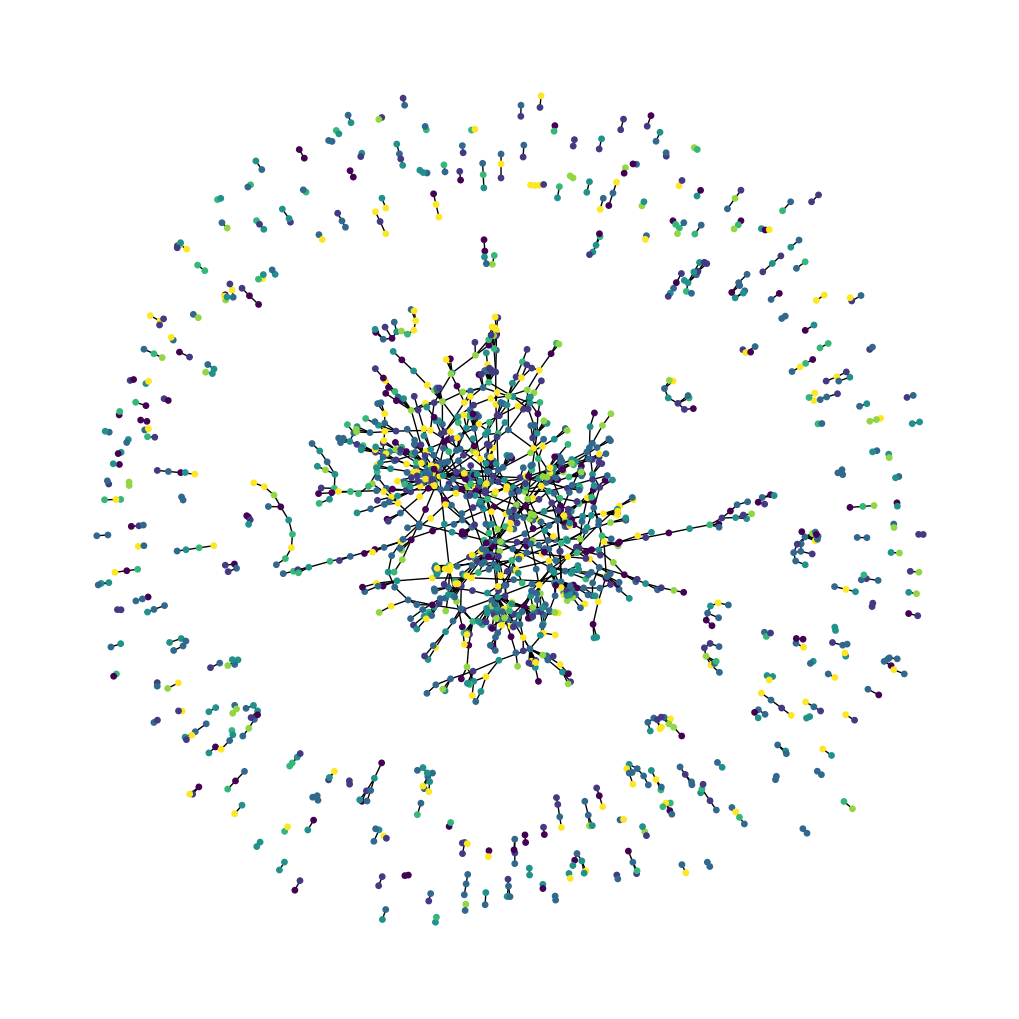

In [12]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

**Explanation of the above graph achieved.**
- <u>Graph Layout:</u>
  - Spring Layout **(nx.draw_spring):**
This layout positions nodes using [Fruchterman-Reingold force-directed algorithm](https://cdn.exec.talentsprint.com/static/cds/content/Fruchterman-Reingold ).
Nodes repel each other like physical particles with repulsive forces, and edges act like springs that pull connected nodes together.
The result is a balanced visual representation where highly connected nodes (or clusters) are closer together, and less connected nodes are more spread out.
- <u>Interpretation of the Graph:</u>
 - **Central Cluster:** The dense central cluster indicates a group of papers that frequently cite each other. This could represent a well-connected subfield or a core area of research within the larger field.
 - **Peripheral Nodes:** Nodes on the periphery represent papers that are less connected. These might be more specialized works or newer papers that haven't been cited much yet.
 - **Node Colors:** Different colors show how papers from different subjects are distributed within the network.
If there are noticeable clusters of the same color, it indicates that papers within the same subject tend to cite each other more frequently.
Mixed colors within clusters suggest interdisciplinary connections.
- <u>Understanding the Sample Size:</u>
 - **Sample of Papers:** The graph shows only a sample of 1500 papers out of the total dataset. This is done to make the visualization clearer and more manageable.
Despite being a sample, the visual can still provide valuable insights into the citation structure and subject distribution.
- <u>Practical Uses:</u>
 - **Identifying central papers and major clusters** can help in understanding key papers and research trends within a field.
 - **Visualizing how different subjects connect** can help in identifying interdisciplinary research opportunities.
 - The above graph is useful for performing further network analysis, such as identifying influential papers (nodes with high centrality)

## Split the dataset into stratified train and test sets

In [13]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1349, 1435)
Test data shape: (1359, 1435)


## Implement Train and Evaluate Experiment

Setting the hyperparameters

In [14]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

The following function **run_experiment()** compiles and trains an input model using the given training data.

This function, **run_experiment()**, trains a given model on training data with the following steps:
- **Model Compilation:** The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy metrics.
- **Early Stopping:** In this function, an early stopping callback is created to monitor validation accuracy **(val_acc)**. If it doesn't improve for 50 epochs, then training stops, and the best weights are restored.
- **Model Training:** The model is trained using the training data **(x_train, y_train)** for a specified number of epochs **(num_epochs)** and batch size **(batch_size)**. The data is split into training and validation sets (85% training, 15% validation). The early stopping callback is used during training.
- **Return History:** The training history, which includes loss and accuracy metrics for each epoch, is returned.

In [15]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

The following function '**display_learning_curves()**' displays the loss and accuracy curves of the model during training.

In [16]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

#Implement Feedforward Network (FFN) Module
The following code module represents the function 'create_ffn()' which will be used in the baseline and the GNN models.

In [17]:
def create_ffn(hidden_units, dropout_rate, name=None):
    # Initialize an empty list to store the layers of the feedforward network
    fnn_layers = []

    # Iterate over the list of hidden units to create layers
    for units in hidden_units:
        # Add a Batch Normalization layer to stabilize and accelerate training
        fnn_layers.append(layers.BatchNormalization())
        # Add a Dropout layer for regularization to prevent overfitting
        fnn_layers.append(layers.Dropout(dropout_rate))
        # Add a Dense layer with the specified number of units and Gaussian Error Linear Units (GELU) activation
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    # Create and return a Sequential model consisting of the defined layers
    return keras.Sequential(fnn_layers, name=name)

#Build a Baseline Neural Network Model

This baseline model provides a straightforward way to evaluate the performance of a simple neural network on the dataset before moving on to more complex models such as Graph Neural Networks (GNNs).
##Prepare the data for the baseline model
- To build a baseline model, the data is first needed to be prepared. This involves selecting features and splitting the data into training and testing sets.


In [18]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

##Implement a baseline classifier
In this section, the baseline classifier is a neural network that uses Fully Connected (FFN) blocks to classify papers into different subjects based on their features.
- **Benchmarking:** Baseline classifier sets up a performance benchmark for evaluating more complex models, such as Graph Neural Networks (GNNs) to be built in the later part of the assignment.
- **Debugging and Validation:** Baseline classifier is implemented to ensure that the data pipeline, feature extraction, and initial model setup are correct.
- **Model Comparison:** Baseline classifier provides a comparison point to quantify the improvements made by more advanced models.

**FFN (Feedforward Neural Network):** The FFN blocks consist of layers that transform the input data into higher-level representations. By stacking multiple FFN blocks, the model can capture complex patterns and relationships in the data. In this baseline model, adding 5 FFN blocks increases the model's capacity to learn from the data.
- **Five FFN blocks with skip connections are added:** By adding five FFN blocks with skip connections, the baseline model is designed to have a similar number of parameters as the GNN models to be built later. This ensures a fair comparison in terms of model complexity and capacity. Having a comparable number of parameters helps in determining whether the GNN architecture provides a genuine performance improvement over the baseline model.
- **Skip connections**, also known as residual connections, are used to address the problem of vanishing gradients and to help with training deep networks. They allow the gradient to flow through the network more easily and enable the model to learn more effectively.
- Skip connections also help in preventing the degradation of training accuracy as the network depth increases.

In [19]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features            │ (None, 1433)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block1 (Sequential)   │ (None, 32)             │         52,804 │ input_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block2 (Sequential)   │ (None, 32)             │          2,368 │ ffn_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection2 (Add)    │ (None, 32)             │              0 │ ffn_block1[0][0],      │
│                           │                        │                │ ffn_block2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block3 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection3 (Add)    │ (None, 32)             │              0 │ skip_connection2[0][0… │
│                           │                        │                │ ffn_block3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block4 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection4 (Add)    │ (None, 32)             │              0 │ skip_connection3[0][0… │
│                           │                        │                │ ffn_block4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block5 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection5 (Add)    │ (None, 32)             │              0 │ skip_connection4[0][0… │
│                           │                        │                │ ffn_block5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 7)              │            231 │ skip_connection5[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 62,507 (244.17 KB)

 Trainable params: 59,065 (230.72 KB)

 Non-trainable params: 3,442 (13.45 KB)

In the above code cell,
- the model starts with an input layer and the first FFN block.
- four additional FFN blocks are added with skip connections to create a deep network.
- the final layer computes the logits for classification.

##Train the baseline classifier

In [20]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - acc: 0.1297 - loss: 5.0611 - val_acc: 0.2365 - val_loss: 1.8933
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2823 - loss: 2.9067 - val_acc: 0.1133 - val_loss: 1.9195
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.2315 - loss: 2.4836 - val_acc: 0.1133 - val_loss: 1.9162
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.2646 - loss: 2.2199 - val_acc: 0.1970 - val_loss: 1.8552
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.3414 - loss: 1.9570 - val_acc: 0.3744 - val_loss: 1.8162
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.3285 - loss: 1.9141 - val_acc: 0.3005 - val_loss: 1.7902
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.3575 - loss: 1.7810 - val_acc: 0.2906 - val_loss: 1.7706
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.3848 - loss: 1.6857 - val_acc: 0.3251 - val_loss: 1.7359
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.4165 - loss

In the above training logs, both training and validation losses decrease initially, which indicates the model is learning.

Plot the learning curves.

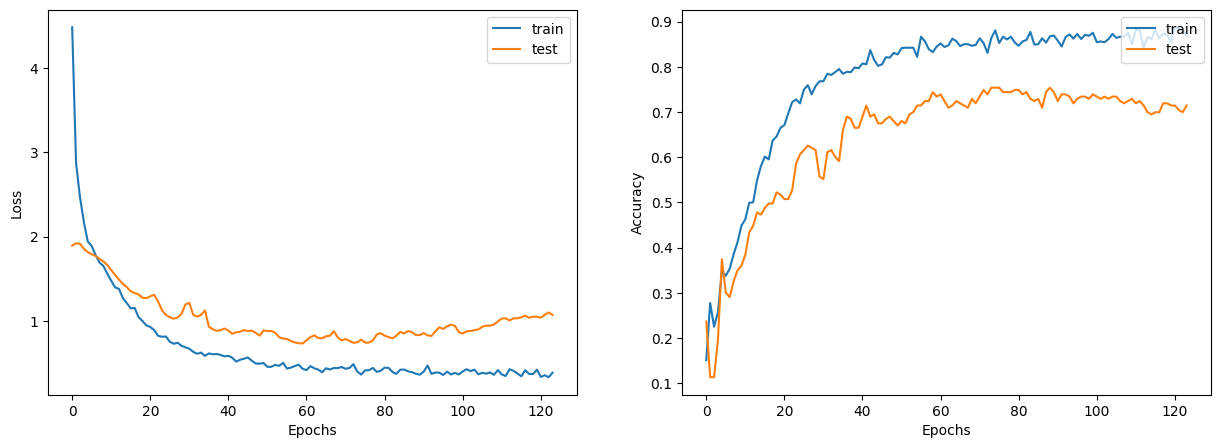

In [21]:
display_learning_curves(history)

**Epochs vs Loss plot:**
- both the training and testing loss decrease over time (or no. of epochs) as the model learns from the training data. This indicates that the model is fitting well the training data.
- as both training loss and testing loss continue to decrease, it indicates there is no overfitting.

**Epochs vs Accuracy plot:**
- both the training and testing accuracy increase over time (or no. of epochs) as the model learns from the training data. This indicates that the model is learning well.
- as both the accuracies (training & testing) increase initially and then get stabilized, hence it indicates there is no overfitting.

Now evaluate the baseline model on the test data split.

In [22]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.03%


##Examine the baseline model predictions

This task ensures that the model behaves as expected on unseen data.
It also helps in understanding whether the model has learned meaningful patterns from the training data.

By evaluating predictions, the performance metrics (e.g., accuracy, precision, recall) can be measured to understand the model's effectiveness.

Create new data instances by randomly generating binary word vectors with respect to the word presence probabilities.
- creating new data instances by randomly generating binary word vectors based on word presence probabilities serves several purposes:
    1. simulates new, unseen data that follows the same distribution as the training data.
    2. helps in evaluating how well the model generalizes to new inputs.
    3. identifies how the model handles outliers or unusual combinations of features.
    4. tests the model's robustness by feeding it random instances.
    5. helps in understanding the impact of different features on model predictions.


**In the following code cell**, the **generate_random_instances()** function is designed to create new data instances by randomly generating binary word vectors based on the word presence probabilities observed in the training data.
- This function takes one parameter **num_instances** which is the number of new data instances to be generated.
- **Calculates Token Probability:**
  - **token_probability = x_train.mean(axis=0):** It calculates the mean presence probability of each word token across all training instances. This provides an estimate of the likelihood of each word being present in a randomly generated instance.
- **Generates Random Instances:**
  - **instances = [ ]:** It initializes an empty list to store the generated instances.
  - **for _ in range(num_instances):** This for loop iterates **num_instances** times to generate the specified number of new instances.
  - **probabilities = np.random.uniform(size=len(token_probability)):** This generates random probabilities between 0 and 1 for each word token, corresponding to whether the word is present in the instance.
  - **instance = (probabilities <= token_probability).astype(int):** It converts the random probabilities to binary values by comparing them with the token probabilities. If the random probability is less than or equal to the token probability, the word is considered present (1), otherwise absent (0).
  - **instances.append(instance):** This adds the generated instance to the list of instances.
- **Returns Generated Instances:**
  - Finally converts the list of generated instances to a NumPy array and returns it.

So, effectively the **generate_random_instances()** function allows for the creation of synthetic data instances that mimic the word presence patterns observed in the training data. This helps in evaluating the baseline model's performance and understanding its behavior when faced with new, unseen data.

In [23]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)

**In the following code cell**, the **display_class_probabilities()** function is designed to present the predicted probabilities of each class for each instance in a human-readable format.
- **Iterating Over Probabilities:**
  - **for instance_idx, probs in enumerate(probabilities):** This for loop iterates over the probabilities of each class for each instance.
  - **instance_idx** keeps track of the index of the instance in the probabilities array, starting from 0.
  - **probs** represents the predicted probabilities for each class for the current instance.
- **Printing Instance Index:**
  - Prints the index of the current instance along with a label indicating it as an instance.
- **Printing Class Probabilities:**
  - **for class_idx, prob in enumerate(probs):** This for loop iterates over the predicted probabilities for each class in the current instance.
  - **class_idx** represents the index of the class, and **prob** represents the probability of the class.
  - **class_values[class_idx]** retrieves the class label associated with the current class index.
  - **round(prob * 100, 2)** calculates the probability percentage rounded to two decimal places.
  - **Finally it prints** the class label and its corresponding probability in percentage format.

So effectively, the following function **display_class_probabilities()** allows for easy interpretation of model predictions by displaying the predicted probabilities of each class for each instance.

It also helps users to understand which classes are more likely for each instance, aiding in decision-making and analysis of baseline model performance.

By presenting the information in a structured and readable manner, it facilitates the evaluation and comparison of different instances and their associated class probabilities.

In [24]:
def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

Now show the baseline model predictions given these randomly generated instances.

In [25]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Instance 1:
- Case_Based: 0.06%
- Genetic_Algorithms: 0.12%
- Neural_Networks: 98.58%
- Probabilistic_Methods: 0.63%
- Reinforcement_Learning: 0.05%
- Rule_Learning: 0.16%
- Theory: 0.4%
Instance 2:
- Case_Based: 1.6%
- Genetic_Algorithms: 39.63%
- Neural_Networks: 42.13%
- Probabilistic_Methods: 5.14%
- Reinforcement_Learning: 4.2%
- Rule_Learning: 0.87%
- Theory: 6.43%
Instance 3:
- Case_Based: 0.12%
- Genetic_Algorithms: 3.26%
- Neural_Networks: 76.52%
- Probabilistic_Methods: 19.24%
- Reinforcement_Learning: 0.57%
- Rule_Learning: 0.05%
- Theory: 0.25%
Instance 4:
- Case_Based: 3.32%
- Genetic_Algorithms: 83.42%
- Neural_Networks: 3.97%
- Probabilistic_Methods: 1.92%
- Reinforcement_Learning: 1.58%
- Rule_Learning: 1.79%
- Theory: 3.99%
Instance 5:
- Case_Based: 2.47%
- Genetic_Algorithms: 0.89%
- Neural_Networks: 29.79%
- Probabilistic_Methods: 3.88%
- Reinforcement_Learning: 8.86%
- Rule_Learning: 39.75%
- Theory: 14.36%
Instance 6:
- Case_B

The above results show 7 instances with the distribution of the class probabilities corresponding to each subject category.

#Build a Graph Neural Network Model

##Prepare the data for the graph model

Preparing and loading graph data for training is a critical and challenging task in GNN models, typically addressed by specialized libraries. Here, a simple approach is demonstrated and this approach is suitable for datasets consisting of a single graph that fits entirely in memory.

The graph data is encapsulated in the graph_info tuple, which includes:

1. **edges**: A [num_edges, num_edges] NumPy array representing a sparse adjacency matrix of links (citations) between nodes (papers).
2. **edge_weights** (optional): A [num_edges] NumPy array of edge weights, all set to one in this example, implying equal influence of all edges.
3. **node_features**: A [num_nodes, num_features] NumPy array where each row represents a node (paper) with a binary feature vector indicating word presence.

For instance, the node_features array has 2708 rows (papers) and 1433 columns (binary word features). The graph_info tuple thus encapsulates the node features, edges, and edge weights, ready for input to a GNN model. This preparation enables the GNN to learn relationships between papers via edges and classify papers using their feature vectors.

In [26]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


The results above indicate the successful preparation of the data for building a Graph Neural Network (GNN) model using the Cora dataset.
- **Edges shape:** The array has 2 rows and 5429 columns. Each column represents an edge (a citation) in the graph, with the first row containing the source nodes (papers) and the second row containing the target nodes (papers). There are 5429 citations (edges) in total.
- **Nodes shape:** The array has 2708 rows and 1433 columns. Each row corresponds to a paper (node) and each column corresponds to a binary feature indicating the presence or absence of a word. There are 2708 papers (nodes) in total, and each paper is represented by a 1433-dimensional feature vector.


##Implement a graph convolution layer
In the following section, a graph convolution module is implemented as a Keras Layer.

The technique implemented uses ideas from Graph Convolutional Networks, GraphSage, Graph Isomorphism Network, Simple Graph Networks, and Gated Graph Sequence Neural Networks.

Two other key techniques (Graph Attention Networks and Message Passing Neural Networks) are not covered in implementation.

**The following code cell** implements the function **create_gru()**.

The function **create_gru()** creates a Keras model consisting of multiple stacked GRU (Gated Recurrent Unit) layers. This model can be used here as the tasks involve sequential data.
- **hidden_units:** This is a list of integers where each integer specifies the number of units (neurons) in a GRU layer.
- **dropout_rate:** This is a float representing the dropout rate, which is used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

**GRU Layer Parameters:**
- **units:** Number of units (neurons) in the GRU layer.
- **activation:** Activation function for the output **(tanh)**.
- **recurrent_activation:** Activation function for the recurrent step **(sigmoid)**.
- **return_sequences:** If True, the GRU layer returns the full sequence output for each input sequence (required when stacking multiple GRU layers). Here, it is set as True.
- **dropout:** Dropout rate for the input units.
- **return_state:** If False, the GRU layer returns only the output. If True, it also returns the last state. Here it is set as False.
- **recurrent_dropout:** Dropout rate for the recurrent state.

In [27]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)

**In the following code cell**, the **GraphConvLayer** class is implemented.

This **GraphConvLayer** performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a message. The processing can be simplified  by only applying linear transformation to the representations. It calls another method **ffn_prepare** within the same class to process the node representations. The result is stored in the **messages** variable.

This is the processed **messages** tensor. If weights were provided, they are applied to the messages before returning the result.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with respect to the **edge_weights** using a permutation invariant pooling operation, such as **sum, mean, and max,** to prepare a single aggregated message for each node. For example, the **tf.math.unsorted_segment_sum** APIs are used to aggregate neighbour messages.
It **Computes** the number of nodes in the graph based on the specified aggregation type:
- **If "sum"**, aggregates neighbour messages using tf.math.unsorted_segment_sum.
- **If "mean"**, aggregates using tf.math.unsorted_segment_mean.
- **If "max"**, aggregates using tf.math.unsorted_segment_max.
- **Otherwise**, raises a ValueError for invalid aggregation types.
- **Output:**
  - **Finally returns** the aggregated message tensor.

3. **Update**: The **node_repesentations** and **aggregated_messages** — both of shape [num_nodes, representation_dim]— are combined and processed to produce the new state of the node representations **(node embeddings).** If **combination_type** is **gru**, the **node_repesentations** and **aggregated_messages** are stacked to create a sequence, then processed by a GRU layer. Otherwise, the **node_repesentations** and **aggregated_messages** are added or concatenated, then processed using the FFN.
It **Applies the processing function (update_fn)** to the combined representations. **When using a GRU (Gated Recurrent Unit)** for combining node representations and aggregated messages, the GRU produces a sequence of outputs.
Then, the **tf.unstack(node_embeddings, axis=1)** separates this sequence along the specified axis (axis=1), creating a list of tensors.
           
  The **Operation: tf.nn.l2_normalize(node_embeddings, axis=-1)** normalizes each embedding vector along the last axis (axis=-1), dividing each vector by its **L2 norm** (the square root of the sum of the squared vector values). **Finally it returns** the updated node embeddings.

In [28]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

##Implement a graph neural network node classifier

The GNN classification model follows the Design Space for Graph Neural Networks approach, as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections, to the node representation to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generate the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.
Each graph convolutional layer added captures information from a further level of neighbours. However, adding many graph convolutional layer can cause oversmoothing, where the model produces similar embeddings for all the nodes.

Note that the graph_info passed to the constructor of the Keras model, and used as a property of the Keras model object, rather than input data for training or prediction. The model will accept a **batch** of **node_indices**, which are used to lookup the node features and neighbours from the **graph_info**.

In [29]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Test instantiating and calling the GNN model. Notice that if N node indices are provided, the output will be a tensor of shape **[N, num_classes]**, regardless of the **size of the graph**.

In [30]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

# Convert the list of node indices to a Tensorflow tensor.
input_node_indices = tf.constant([1, 10, 100])

# Call the model with the input_node_indices tensor.
print("GNN output shape:", gnn_model(input_node_indices))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.00910518 -0.00599628  0.05204612 -0.10886214 -0.01102126  0.04635568
   0.15714268]
 [ 0.08400984 -0.075813   -0.05235824  0.00968577  0.17436069 -0.14241421
   0.14074606]
 [ 0.0482364  -0.06075194  0.06698356 -0.09716076 -0.02369282  0.05612785
   0.08584789]], shape=(3, 7), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 32)                  │          52,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │           5,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (2708, 32)                  │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (3, 7)                      │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,179 (262.42 KB)

 Trainable params: 63,481 (247.97 KB)

 Non-trainable params: 3,698 (14.45 KB)

The model architecture consists the following sequential layers:

**Input Node Features --> Preprocess Layer --> Graph Conv Layer 1 --> Graph Conv Layer 2 --> Postprocess Layer --> Dense Layer (Logits) --> Class Probabilities**

**Layers and Their Roles in the above GNN model summary:**
1. Preprocess (Sequential):
  - Output Shape: (2708, 32)
  - Param #: 52804
  - This layer processes the input node features, transforming them into a 32-dimensional space. It consists of a sequence of operations, typically including linear transformations and possibly some non-linear activations.
2. GraphConvLayer (graph_conv1):
  - Output Shape: Multiple
  - Param #: 5888
  - This is the first graph convolution layer. It aggregates information from neighboring nodes to update the node representations.
3. GraphConvLayer (graph_conv2):
  - Output Shape: Multiple
  - Param #: 5888
  - This is the second graph convolution layer, further refining the node representations by aggregating information from the neighbors.
4. Postprocess (Sequential):
  - Output Shape: (2708, 32)
  - Param #: 2368
  - This layer further processes the node representations after the graph convolution layers. It typically involves additional transformations to prepare the data for the final classification layer.
5. Logits (Dense):
  - Output Shape: Multiple
  - Param #: 231
  - This is the number of parameters in the dense layer, which includes the weights and biases. For a dense layer with 32 input units and 7 output units (one for each class), you would have $32 × 7 = 224$ weights plus $7$ biases, resulting in $231$ parameters.
  - This is the final dense layer that produces the logits for each of the $7$ classes. The output shape corresponds to the number of classes (i.e., $7$), and the logits are the raw scores before applying the softmax function to get the class probabilities.
  - The dense layer's output shape "multiple" indicates that it can handle different batch sizes or number of nodes during prediction. As here the gnn_model predicts for specific nodes i.e., $[1, 10, 100]$, the model processes the features for these $3$ nodes and outputs logits for each node across all 7 classes. **Hence, the output shape becomes $(3, 7)$**.

**Parameters in the above GNN Model:**
  - Total params: 67179

    - The total number of parameters in the model, including both trainable and non-trainable parameters.
  - Trainable params: 63481
    - The number of parameters that will be updated during training.
  - Non-trainable params: 3698
    - The number of parameters that are not updated during training. These could be static weights or hyperparameters.

##Train the GNN model
Note that we use the standard supervised cross-entropy loss to train the model. However, another self-supervised loss term can be added for the generated node embeddings that makes sure that neighbouring nodes in graph have similar representations, while faraway nodes have dissimilar representations.

In [31]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - acc: 0.2702 - loss: 1.8866 - val_acc: 0.2808 - val_loss: 1.7542
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.3476 - loss: 1.6020 - val_acc: 0.3842 - val_loss: 1.6180
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - acc: 0.5776 - loss: 1.1345 - val_acc: 0.6158 - val_loss: 1.1079
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - acc: 0.7875 - loss: 0.6303 - val_acc: 0.6355 - val_loss: 1.4795
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.8405 - loss: 0.4953 - val_acc: 0.7044 - val_loss: 1.1788
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - acc: 0.9167 - loss: 0.2373 - val_acc: 0.6847 - val_loss: 1.1982
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - acc: 0.9563 - loss: 0.1325 - val_acc: 0.6700 - val_loss: 1.3183
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - acc: 0.9778 - loss: 0.0720 - val_acc: 0.6798 - val_loss: 1.3855
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - acc: 0.9904 - loss

Plot the learning curves

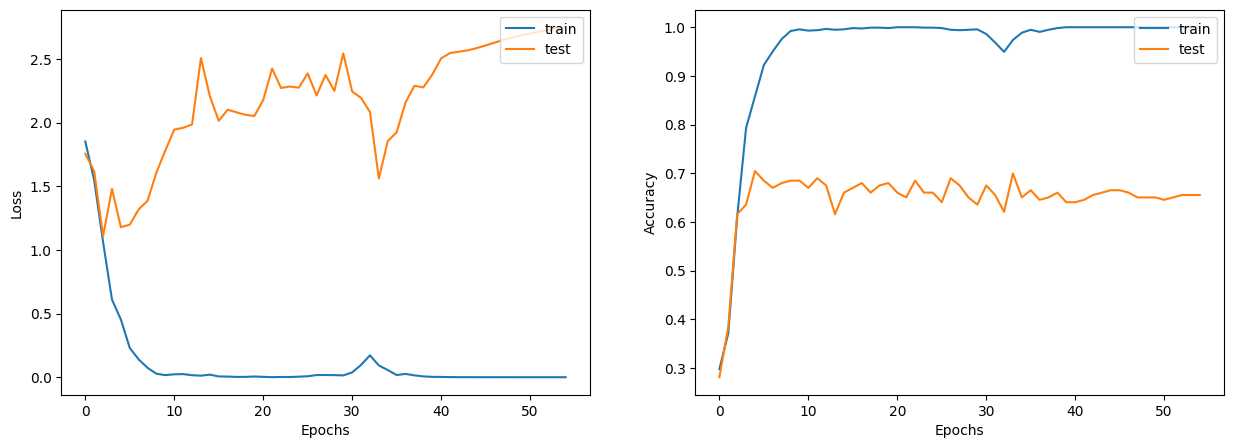

In [32]:
display_learning_curves(history)

From the above plots, the following interpretations can be drawn.

**Interpretation for Epoch vs Loss plot of the GNN Model:**

- Initial High Loss: At the start of training, both the training and validation losses are high. This indicates that the GNN model is not yet well-fitted to the data.
- Decreasing Training Loss: As training (i.e., the No. of Epochs) progresses, the training loss decreases significantly, indicating that the model is learning from the training data and improving its fit. The final training loss is low, showing effective learning.
- Decreasing Validation Loss: The validation loss also decreases initially, suggesting that the model is generalizing well to unseen data. Periodic spikes in validation loss can occur due to the model encountering particularly difficult batches of validation data.
- Flattening Out: After many epochs (i.e., after 160 Epochs), both the training and validation losses tend to plateau, indicating that the model has reached a state of near-optimal performance.
- Convergence: By the end of training (i.e., around epoch 300), the training loss is very low, and the validation loss has decreased considerably from its initial value.

**Interpretation for Epoch vs Accuracy plot of the GNN Model:**
- Initial Low Accuracy: At the start of training, both the training and validation accuracies are low, indicating that the model is not yet making good predictions.
- Increasing Training Accuracy: As training (i.e., No. of Epochs) progresses, the training accuracy increases, showing that the model is learning and making better predictions on the training data.
- Increasing Validation Accuracy: The validation accuracy also increases, suggesting that the model is generalizing well to unseen data.
- Plateauing: After many epochs (i.e., afyer 160 Epochs), both the training and validation accuracies tend to plateau, indicating that further training is providing diminishing returns.
- High Final Accuracy: By the end of training (i.e., around epoch 300), the training accuracy is very high, often approaching 90-100%.
- Validation Accuracy: The validation accuracy is also significantly improved from the start, though it may be slightly lower than the training accuracy due to some amount of overfitting or noise in the validation set.

Now evaluate the GNN model on the test data split. The results may vary depending on the training sample, however the GNN model always outperforms the baseline model in terms of the test accuracy.

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

As per the above result, the **Test accuracy of $80.7$%** indicates that the GNN model correctly classifies approximately $80.7%$ of the papers in the test dataset.

The GNN model outperforms the baseline model. This is because GNNs are designed to make use of the structural information inherent in graph data, such as in this case, the citation network in the Cora dataset.

By incorporating information from neighboring nodes (i.e., citations), the GNN can capture more complex patterns and relationships than a baseline model, which may only use node features without considering the graph structure.

The GNN model maintains superior accuracy compared to the baseline. The test accuracy reflects the model's ability to generalize well to new data, indicating that it is not overfitted to the training data.

##Examine the GNN model predictions
Now add the new instances as nodes to the **node_features**, and generate links (citations) to existing nodes. The following code cell adds num_nodes to the graph by appending the new_instances to node_features. The steps are described below.

1. **Add New Nodes to the Graph:**
   - **num_nodes:** This is the original number of nodes in the graph.
   - **new_node_features:** This is a new array of node features created by appending the features of the new instances (new_instances) to the original node features (node_features).
   - **Significance:** The Node Addition process integrates new nodes (representing new instances) into the existing graph, expanding its structure.
2. **Identify New Node Indices:**
   - **new_node_indices:** These are the indices for the new nodes, calculated by adding the total number of original nodes to the range of the number of classes.
   - **Significance:** This step identifies new node indices which ensures that the newly added nodes are correctly indexed and distinct from the original nodes. It also maintains the integrity of the graph structure and enables accurate reference & manipulation in subsequent steps.
3. **Create New Citations (Edges):**
   - **new_citations:** It is a list to store the new edges.
   - **Loop through** each subject group in the papers DataFrame.
   - **For each subject group:**
     - **subject_papers:** This is the List of papers belonging to the current subject.
     - **selected_paper_indices1:** Randomly select 5 papers from the current subject.
     - **selected_paper_indices2:** Randomly select 2 papers from any subject.
     - **selected_paper_indices:** Concatenate the selected indices from the current subject and any subject.
     - **citing_paper_indx:** This is the index of the new node that cites other papers.
     - **Create new edges** from the new node (citing_paper_indx) to the selected papers (cited_paper_idx).
   - **Significance:** New Edges creation establishes relationships (citations) between new nodes and existing nodes, reflecting the interconnected nature of the data.
4. **Update Edge List:**
     - **new_citations:** Convert the list of new citations to a NumPy array and transpose it.
     - **new_edges:** Concatenate the original edges with the new citations to create the updated list of edges.
     - **Significance:** Tthe final concatenation step updates the graph (Graph update) to include both the new nodes and the new edges, making it ready for further analysis or model training.

In [33]:
# First add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

Now update the node_features and the edges in the GNN model.

In [34]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Instance 1:
- Case_Based: 0.38%
- Genetic_Algorithms: 1.0%
- Neural_Networks: 91.09%
- Probabilistic_Methods: 1.14%
- Reinforcement_Learning: 4.54%
- Rule_Learning: 0.22%
- Theory: 1.62%
Instance 2:
- Case_Based: 0.02%
- Genetic_Algorithms: 98.5%
- Neural_Networks: 0.83%
- Probabilistic_Methods: 0.05%
- Reinforcement_Learning: 0.24%
- Rule_Learning: 0.06%
- Theory: 0.3%
Instance 3:
- Case_Based: 0.02%
- Genetic_Algorithms: 0.39%
- Neural_Networks: 97.99%
- Probabilistic_Methods: 1.03%
- Reinforcement_Learning: 0.53%
- Rule_Learning: 0.0%
- Theory: 0.03%
Instance 4:
- Case_Based: 0.4%
- Genetic_Algorithms: 73.18%
- Neural_Networks: 1.54%
- Probabilistic_Methods: 0.13%
- Reinforcement_Learning: 2.47%
- Rule_Learning: 10.08%
- Theory: 12.21%
Instance 5:
- Case_Based: 1.22%
- Genetic_Algorithms: 7.16%
- Neural_Networ

In the above results, notice that the probabilities of the expected subjects (to which several citations are added) are higher compared to the baseline model.

- **Original node_features shape:** (2708, 1433): This indicates that the original graph had 2,708 nodes (papers), each represented by a feature vector of size 1,433.
- **Original edges shape:** (2, 5429): This shows there were 5,429 edges (citations) in the original graph.
- **New node_features shape:** (2715, 1433): After adding the new instances, the graph now has 2,715 nodes.
- **New edges shape:** (2, 5478): After adding the new citations, the graph now has 5,478 edges.

The above results show 7 instances with the Class Probabilities for New Instances corresponding to each subject category.

### Please answer the questions below to complete the experiment:

In [35]:
# @title Select the correct statement: In the create_baseline_model() function, the skip_connection is used in order to address the problem of { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "vanishing gradients and to help with training deep networks." #@param["","memory leakage and to help with training deep networks.","vanishing gradients and to help with training deep networks.","underfitting and to reduce model complexity."]

In [36]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [37]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "Its a very big notebook" #@param {type:"string"}


In [38]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [39]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [40]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [41]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 6875
Date of submission:  14 Dec 2024
Time of submission:  22:04:51
View your submissions: https://cds-iisc.talentsprint.com/notebook_submissions
